In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns 
import pylab as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pd.set_option('display.max_colwidth', 100)
engine1h = pd.read_csv(r'/content/drive/MyDrive/Bases_de_datos/Engine3_1h.csv', encoding="ISO-8859-1")
engine1h.head()

,Unnamed: 0,Date_time,THRM_EFF_BTU
0,0,01/01/2021 00:00,22.910171
1,1,01/01/2021 01:00,22.856912
2,2,01/01/2021 02:00,22.918531
3,3,01/01/2021 03:00,22.942700
4,4,01/01/2021 04:00,22.863096


In [4]:
engine1h.index = pd.to_datetime(engine1h['Date_time'])
engine1h.drop(columns='Date_time',inplace=True)
engine1h.drop(['Unnamed: 0'], axis=1, inplace=True)
engine1h.head()

,THRM_EFF_BTU
Date_time,
2021-01-01 00:00:00,22.910171
2021-01-01 01:00:00,22.856912
2021-01-01 02:00:00,22.918531
2021-01-01 03:00:00,22.942700
2021-01-01 04:00:00,22.863096


In [5]:
engine1h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2021-01-01 00:00:00 to 2022-01-01 00:00:00
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   THRM_EFF_BTU  8761 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


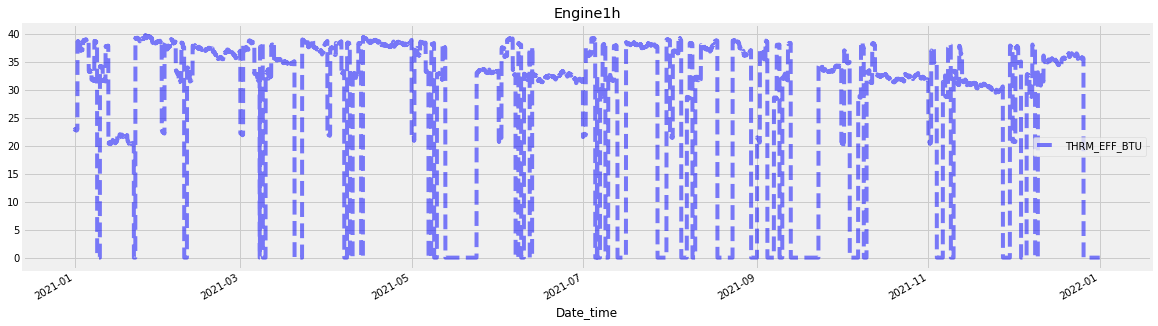

In [6]:
engine1h.plot(style='--', figsize=(18, 5), color='b', alpha=0.5, title='Engine1h');

In [7]:
def time_features(df): 
  """
  Esta función extrae características de tiempo 
  a una columna de fecha.
  """

  df = df.copy()

  df['date'] = df.index
  df['hour'] = df.date.dt.hour
  df['day_of_week'] = df.date.dt.dayofweek
  df['quarter'] = df.date.dt.quarter
  df['month'] = df.date.dt.month
  df['year'] = df.date.dt.year
  df['day_of_year'] = df.date.dt.dayofyear
  df['day_of_month'] = df.date.dt.day
  df['week_of_year'] = df.date.dt.weekofyear
  
  return df

In [8]:
data = time_features(engine1h).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [9]:
data.head()

,THRM_EFF_BTU,date,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year
Date_time,,,,,,,,,,
2021-01-01 00:00:00,22.910171,2021-01-01 00:00:00,0,4,1,1,2021,1,1,53
2021-01-01 01:00:00,22.856912,2021-01-01 01:00:00,1,4,1,1,2021,1,1,53
2021-01-01 02:00:00,22.918531,2021-01-01 02:00:00,2,4,1,1,2021,1,1,53
2021-01-01 03:00:00,22.942700,2021-01-01 03:00:00,3,4,1,1,2021,1,1,53
2021-01-01 04:00:00,22.863096,2021-01-01 04:00:00,4,4,1,1,2021,1,1,53


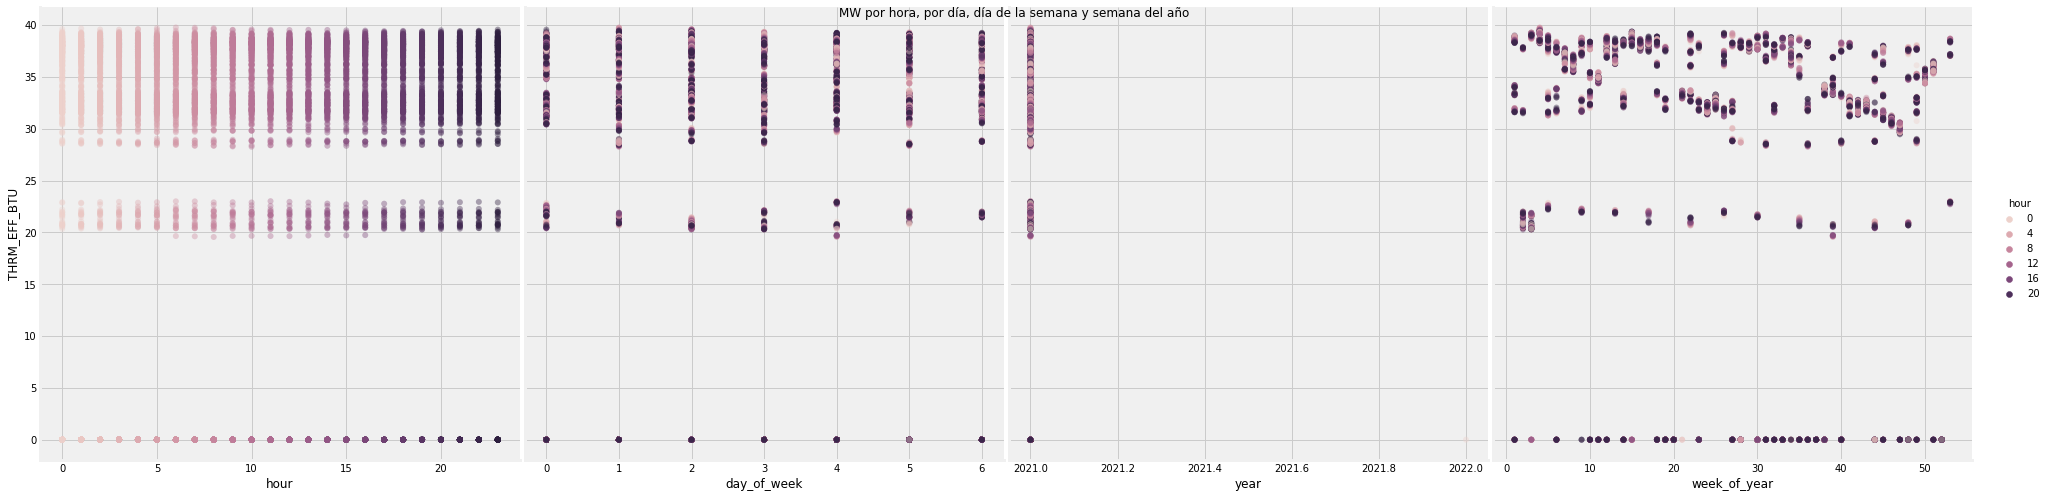

In [10]:
sns.pairplot(data, hue='hour', 
             x_vars=['hour', 'day_of_week', 'year', 'week_of_year'],
             y_vars='THRM_EFF_BTU', height=7, plot_kws={'alpha': 0.4, 'linewidth': 0})
plt.suptitle('MW por hora, por día, día de la semana y semana del año')
plt.show();

In [12]:
split_date = '01-Nov-2021'

train = engine1h.loc[engine1h.index <= split_date].copy()
test = engine1h.loc[engine1h.index > split_date].copy()

train = train.reset_index().rename(columns={'Date_time': 'ds', 'THRM_EFF_BTU': 'y'})
test = test.reset_index().rename(columns={'Date_time': 'ds', 'THRM_EFF_BTU': 'y'})

In [13]:
test.head()

,ds,y
0,2021-11-01 01:00:00,21.060920
1,2021-11-01 02:00:00,21.074256
2,2021-11-01 03:00:00,21.050866
3,2021-11-01 04:00:00,21.040795
4,2021-11-01 05:00:00,21.017171


In [14]:
test = test.fillna(0)
test.tail()

,ds,y
1459,2021-12-31 20:00:00,0.0
1460,2021-12-31 21:00:00,0.0
1461,2021-12-31 22:00:00,0.0
1462,2021-12-31 23:00:00,0.0
1463,2022-01-01 00:00:00,0.0


In [15]:
%%time

modelo = Prophet().fit(train)
prediccion = modelo.predict(test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


CPU times: user 12.9 s, sys: 5.08 s, total: 17.9 s
Wall time: 19.5 s


In [16]:
test_fetch = pd.DataFrame(['2021-11-01 00:00:00'], columns=['ds'])
test_fetch

,ds
0,2021-11-01 00:00:00


In [17]:
predict_date = modelo.predict(test_fetch)
predict_date

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-01,28.525587,10.224283,45.895637,28.525587,28.525587,0.057656,0.057656,0.057656,0.059274,0.059274,0.059274,-0.001618,-0.001618,-0.001618,0.0,0.0,0.0,28.583243


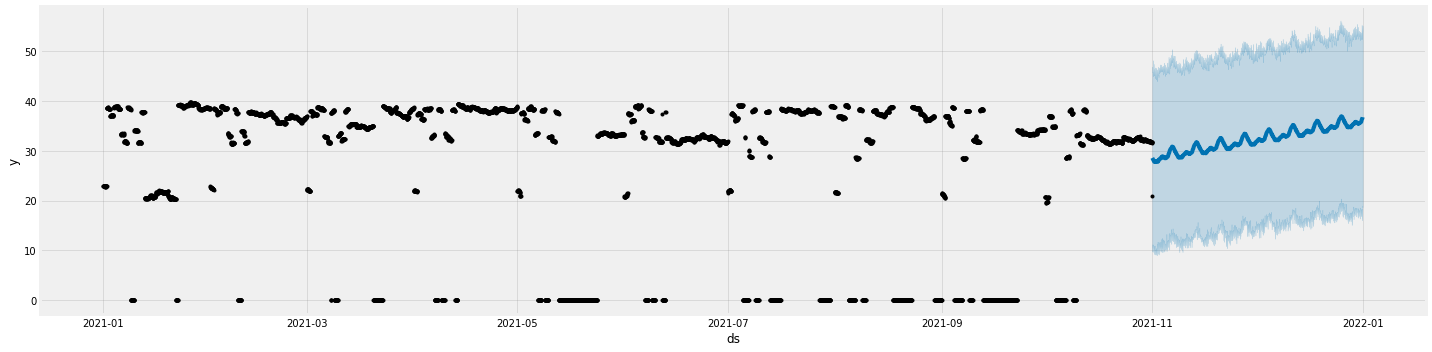

In [18]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(20)
f = modelo.plot(prediccion, ax=ax)

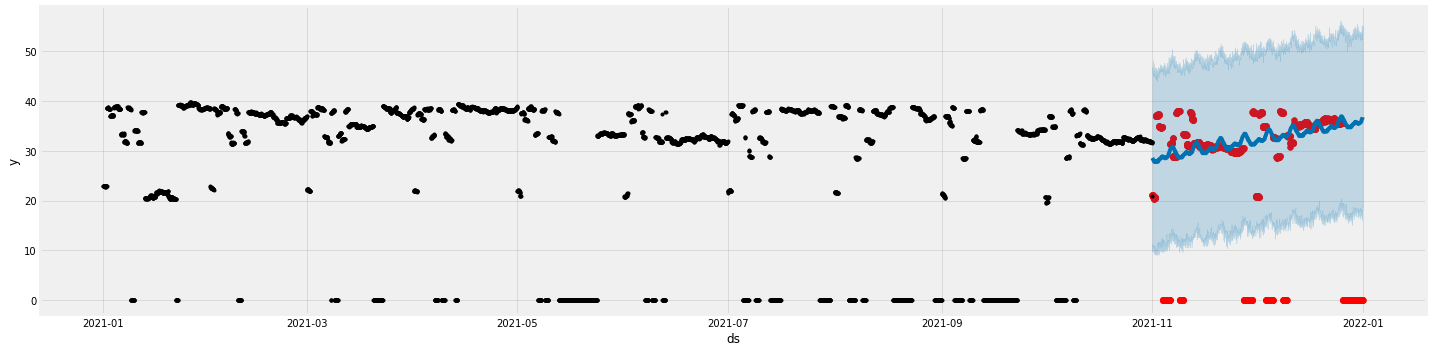

In [19]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(20)
ax.scatter(test.ds, test.y, color='r')
f = modelo.plot(prediccion, ax=ax)

In [20]:
# Root Mean Square Error, raíz del error cuadrático medio 

mse(test.y, prediccion.yhat) ** 0.5

16.187324641265473

In [21]:
mean_absolute_percentage_error(test.y, prediccion.yhat)

3.4712769275164996e+16